In [1]:
# !pip install scikit-learn
# !pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Drop the Survived column to keep only features
features = data.drop(columns=['Survived'])
# Convert all columns to string
features = features.astype(str)
# Concatenate all rows
data['text'] = features.apply(lambda x: ' '.join(x), axis=1)

In [5]:
def clean_text(text):
    text = text.lower() # convert to lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text) # remove non-alphanumeric characters
    return text

data['text'] = data['text'].apply(clean_text)

In [6]:
def clean_html(text):
    CLEANR = re.compile("<.*?>:")
    text = re.sub(CLEANR, ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A) #lower case
    return text
    
def rem_lines(text):
    return text.strip().replace('\n', ' ')
    
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, EMOTICONS_EMO[emot]+" ".replace("",""))
    return text
    
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot,UNICODE_EMOJI[emot]+" ".replace("",""))
    return text
    
def remove_stopwords(text):
    return [word for word in word_tokenize(text) if not word in stopwords]

def strip_punctuation(text):
    return ''.join(c for c in text if c not in punctuation)+' '

def to_number(text):
    return(re.sub(r"(\d+)", lambda x: num2words(int(x.group(0))), text))

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return ' '.join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [7]:
def number_to_words(text):
    word_map = {
        '0': 'zero',
        '1': 'one',
        '2': 'two',
        '3': 'three',
        '4': 'four',
        '5': 'five',
        '6': 'six',
        '7': 'seven',
        '8': 'eight',
        '9': 'nine'
    }
    return ' '.join([word_map.get(i, i) for i in text.split()])

data['text'] = data['text'].apply(number_to_words)

In [8]:
print(data[['text']].head())

                                                text
0  one three braund mr owen harris male 220 one z...
1  two one cumings mrs john bradley florence brig...
2  three three heikkinen miss laina female 260 ze...
3  four one futrelle mrs jacques heath lily may p...
4  five three allen mr william henry male 350 zer...


In [9]:
print(data[['text']].sample(5))


                                                  text
615  616 two herman miss alice female 240 one two 2...
674  675 two watson mr ennis hastings male nan zero...
59   60 three goodwin master william frederick male...
39   40 three nicolayarred miss jamila female 140 o...
567  568 three palsson mrs nils alma cornelia bergl...


In [10]:
print(data['text'].nunique())

891


In [11]:
print(data.loc[0, 'text']) # This prints the text data for the first row

one three braund mr owen harris male 220 one zero a5 21171 725 nan s


In [12]:
for word in ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']:
    print(f"{word} occurs {data['text'].str.count(word).sum()} times.")


zero occurs 1286 times.
one occurs 554 times.
two occurs 305 times.
three occurs 515 times.
four occurs 23 times.
five occurs 11 times.
six occurs 2 times.
seven occurs 1 times.
eight occurs 8 times.
nine occurs 3 times.


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['Survived'], test_size=0.2, random_state=42)
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
# Train a classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)
# Predict and evaluate
y_pred = clf.predict(X_val_vec)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.79


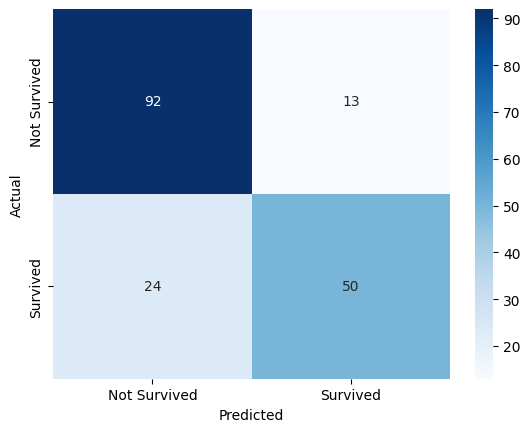

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
mat = confusion_matrix(y_val, y_pred)
sns.heatmap(mat, annot=True, fmt='d', cmap='Blues',
xticklabels=['Not Survived', 'Survived'],
yticklabels=['Not Survived', 'Survived'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred, target_names=['Not Survived', 'Survived']))


              precision    recall  f1-score   support

Not Survived       0.79      0.88      0.83       105
    Survived       0.79      0.68      0.73        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



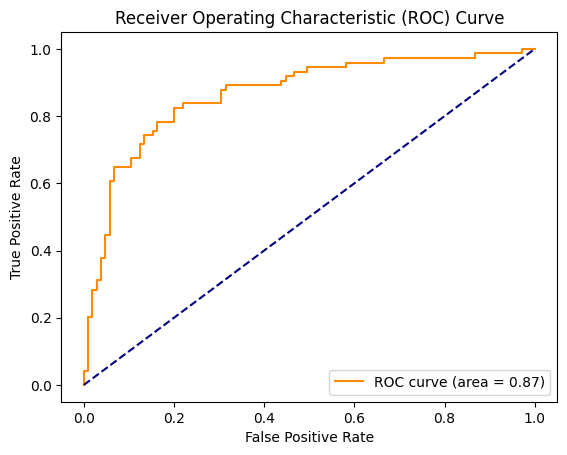

In [16]:
from sklearn.metrics import roc_curve, auc
y_prob = clf.predict_proba(X_val_vec)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

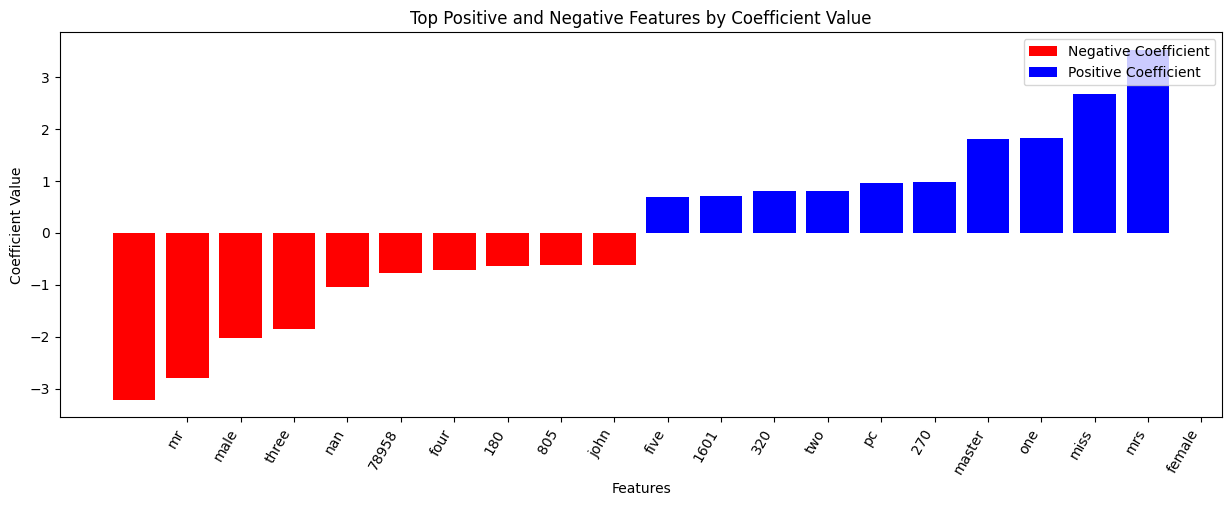

In [17]:
def display_top_features(coefficients, feature_names, top_n=10):
    coef = coefficients.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_n:]
    top_negative_coefficients = np.argsort(coef)[:top_n]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    bars = plt.bar(np.arange(2 * top_n), coef[top_coefficients], color=colors)
    # Adding legend
    plt.legend([bars[0], bars[-1]], ['Negative Coefficient', 'Positive Coefficient'], loc='upper right')
    # Adding labels and title
    plt.xticks(np.arange(1, 1 + 2 * top_n), np.array(feature_names)[top_coefficients], rotation=60, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.title('Top Positive and Negative Features by Coefficient Value')
    plt.show()
# Call the function
display_top_features(clf.coef_, vectorizer.get_feature_names_out())

In [23]:
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import TfidfVectorizer as TFIDF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report as CR
from sklearn.linear_model import LogisticRegression as LR
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

from spacymoji import Emoji #for EMOTICONS
from emot.emo_unicode import UNICODE_EMOJI #for EMOJIS
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS
import re
import string
from string import punctuation
from num2words import num2words
import matplotlib
import matplotlib.pyplot as plt #for plotting

In [18]:
print(data[['text']].head())

                                                text
0  one three braund mr owen harris male 220 one z...
1  two one cumings mrs john bradley florence brig...
2  three three heikkinen miss laina female 260 ze...
3  four one futrelle mrs jacques heath lily may p...
4  five three allen mr william henry male 350 zer...


In [21]:
#split into training/test data
from sklearn.model_selection import train_test_split as tts
trainX, testX, trainy, testy= tts(data['text'],data['Survived'],test_size=0.2,random_state=42)

In [24]:
#bag of words grouping
cv = CountVectorizer(binary=True, ngram_range=(1,1),min_df=0.0,max_df=1.0)
cv_train = cv.fit_transform(trainX)
cv_test = cv.transform(testX)

In [25]:
#TF-IDF
tv = TFIDF(use_idf=True, min_df=0.0,max_df=1.0)
tv_train = tv.fit_transform(trainX)
tv_test = tv.transform(testX)

In [ ]:
# TF-IDF
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
# Train a classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)
# Predict and evaluate
y_pred = clf.predict(X_val_vec)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

In [29]:

# Create an instance of the Logistic Regression model
lr = LR(penalty='l2', max_iter=500, C=1, random_state=42)

# Fit the model to your training data
lr.fit(tv_train, trainy)


LogisticRegression(C=1, max_iter=500, random_state=42)

In [30]:
from sklearn.metrics import classification_report, accuracy_score

# TF-IDF
tv = TFIDF(use_idf=True, min_df=0.0, max_df=1.0)
tv_train = tv.fit_transform(trainX)
tv_test = tv.transform(testX)

# Train a classifier (you can use any classifier you prefer)
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(tv_train, trainy)

# Predict on the test set
y_pred = clf.predict(tv_test)

# Calculate accuracy
accuracy = accuracy_score(testy, y_pred)
print("Accuracy:", accuracy)

# Generate and print the classification report
report = classification_report(testy, y_pred)
print("Classification Report:\n", report)


Accuracy: 0.7932960893854749
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       105
           1       0.79      0.68      0.73        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [31]:
from sklearn.metrics import classification_report, accuracy_score

# Create an instance of the Logistic Regression model
lr = LR(penalty='l2', max_iter=500, C=1, random_state=42)

# Fit the model to your training data
lr.fit(tv_train, trainy)

# Predict on the test set
y_pred = lr.predict(tv_test)

# Calculate accuracy
accuracy = accuracy_score(testy, y_pred)
print("Accuracy:", accuracy)

# Generate and print the classification report
report = classification_report(testy, y_pred)
print("Classification Report:\n", report)


Accuracy: 0.7932960893854749
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       105
           1       0.79      0.68      0.73        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

